In [29]:
import random
import string
import re
import sys
import nltk
import spacy
import torch

import pandas as pd
import numpy as np
import scipy.sparse as sps
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as opt
import torch.utils.data as dt

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV

from spacy import displacy

from nlp_project.notebook_utils import evaluate, split
from nlp_project.nn_utils import init_gpu
from nlp_project.nn_classifier import Data, Classifier
from nlp_project.nn_extra import EarlyStopping, AdaptLR

In [2]:
seed = 69420
np.random.seed(seed)
random.seed(seed)

In [6]:
%%capture # noqa

# Classification labels
labels = ["generated", "human"]

# English stopwords
nltk.download("stopwords")
eng_stopwords = nltk.corpus.stopwords.words("english")

# Load spacy pipeline model
!{sys.executable} -m spacy download en_core_web_sm
#import en_core_web_sm
nlp_model = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to /home/riga/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# Import main dataset
df = pd.read_csv("../../AUTEXTIFICATION/subtask_1/train.tsv", sep="\t")
df = df.drop("id", axis=1)

df

,text,label
0,you need to stop the engine and wait until it ...,generated
1,The Commission shall publish the report; an in...,generated
2,"I have not been tweeting a lot lately, but I d...",generated
3,I pass my exam and really thankgod for that bu...,human
4,The template will have 3 parts: a mustache sha...,human
...,...,...
33840,"@PierreJoye i have a server already, thanks fo...",human
33841,10. Article 13 of Council Directive 80/777/EEC...,human
33842,"Crying because I have to cry for you?. No. No,...",generated
33843,"However, it will continue to offer customers a...",generated


In [9]:
def extract_features(tree):
    features = []
    for token in tree:
        lemma = token.lemma_
        pos_tag = token.pos_
        dep_lab = token.dep_
        head = token.head
        if token.i < head.i:
            direction = "l"
        else:
            direction = "r"
        dfr = len(list(token.ancestors))
        # if not token.is_stop:
        features.append({
            "lem": lemma ,
            "pos": pos_tag, 
            "dep": dep_lab, 
            "head": head, 
            "dir": direction, 
            "dfr": dfr
        })
    return features

In [10]:
# Run SpaCy NLP pipeline on dataset
parsed_df = df.copy()
parsed_df["text"] = df["text"].apply(lambda x: nlp_model(x))

In [11]:
# Extract useful features
parsed_df["features"] = parsed_df["text"].apply(lambda x: extract_features(x))
parsed_df

,text,label,features
0,"(you, need, to, stop, the, engine, and, wait, ...",generated,"[{'lem': 'you', 'pos': 'PRON', 'dep': 'nsubj',..."
1,"(The, Commission, shall, publish, the, report,...",generated,"[{'lem': 'the', 'pos': 'DET', 'dep': 'det', 'h..."
2,"(I, have, not, been, tweeting, a, lot, lately,...",generated,"[{'lem': 'I', 'pos': 'PRON', 'dep': 'nsubj', '..."
3,"(I, pass, my, exam, and, really, thankgod, for...",human,"[{'lem': 'I', 'pos': 'PRON', 'dep': 'nsubj', '..."
4,"(The, template, will, have, 3, parts, :, a, mu...",human,"[{'lem': 'the', 'pos': 'DET', 'dep': 'det', 'h..."
...,...,...,...
33840,"(@PierreJoye, i, have, a, server, already, ,, ...",human,"[{'lem': '@PierreJoye', 'pos': 'PROPN', 'dep':..."
33841,"(10, ., Article, 13, of, Council, Directive, 8...",human,"[{'lem': '10', 'pos': 'X', 'dep': 'ROOT', 'hea..."
33842,"(Crying, because, I, have, to, cry, for, you, ...",generated,"[{'lem': 'cry', 'pos': 'VERB', 'dep': 'ROOT', ..."
33843,"(However, ,, it, will, continue, to, offer, cu...",generated,"[{'lem': 'however', 'pos': 'ADV', 'dep': 'advm..."


In [8]:
# Example structure
displacy.render(parsed_df["text"][0], jupyter=True, style='dep')

In [12]:
# Vectorize lemmas
vectorizer = CountVectorizer()
parsed_df["text_lem"] = parsed_df["features"].apply(lambda x: " ".join([t["lem"] for t in x]))
x = vectorizer.fit_transform(parsed_df["text_lem"])
y = parsed_df["label"]

In [28]:
x_train, x_val, x_test, y_train, y_val, y_test = split(x, y, test_size=0.2, val_size=0.0)

In [33]:
models = []

# Naive Bayes
nb = MultinomialNB()
nb_param = {"alpha":[0.001, 0.01, 0.1, 1, 10, 100]}
nb_clf = GridSearchCV(nb, nb_param, cv=5, scoring="f1_micro", verbose=1)
models.append({"name": "Naive Bayes", "model": nb_clf})

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr_param = [{
    "solver": ["liblinear"], 
    "penalty": ["l1", "l2"],
    "C":[0.01, 0.1, 1, 10]
},{
    "solver": ("lbfgs", "sag", "saga"), 
    "penalty": ["l2"],
    "C":[0.01, 0.1, 1]
}]
lr_clf = GridSearchCV(lr, lr_param, cv=5, scoring="f1_micro", verbose=1)
models.append({"name": "Linear Regression", "model": lr_clf})

# SVC
svc = SVC()
svc_param = {"kernel": ["rbf"], "C": [0.1, 1, 10]}
svc_clf = GridSearchCV(svc, svc_param, cv=5, scoring="f1_micro", verbose=1)
models.append({"name": "SVC", "model": svc_clf, "subsample": 0.7})

In [34]:
for model in models:
    print(f"Training {model['name']}")
    
    x_train_, y_train_ = x_train, y_train
    if "subsample" in model.keys():
        x_train_, _, y_train_, _ = train_test_split(
            x_train, 
            y_train, 
            test_size=model["subsample"], 
            stratify=y_train
        )
        
    model["model"].fit(x_train_, y_train_)
    
    print("Found best model")
    model["best"] = model["model"].best_estimator_
    model["best"].fit(x_train, y_train)
    print("Trained best model")

Training Naive Bayes
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Found best model
Trained best model
Training Linear Regression
Fitting 5 folds for each of 17 candidates, totalling 85 fits


/home/riga/.cache/pypoetry/virtualenvs/nlp-project-McHdYL_A-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/riga/.cache/pypoetry/virtualenvs/nlp-project-McHdYL_A-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/riga/.cache/pypoetry/virtualenvs/nlp-project-McHdYL_A-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/riga/.cache/pypoetry/virtualenvs/nlp-project-McHdYL_A-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/riga/.cache/pypoetry/virtualenvs/nlp-project-McHdYL_A-py3.11/lib/pytho

Found best model
Trained best model
Training SVC
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Found best model
Trained best model


Naive Bayes
Best parameters: {'alpha': 1}
Best CV score: 0.7009898443925253
              precision    recall  f1-score   support

   generated       0.67      0.80      0.73      3360
       human       0.75      0.61      0.68      3409

    accuracy                           0.70      6769
   macro avg       0.71      0.70      0.70      6769
weighted avg       0.71      0.70      0.70      6769



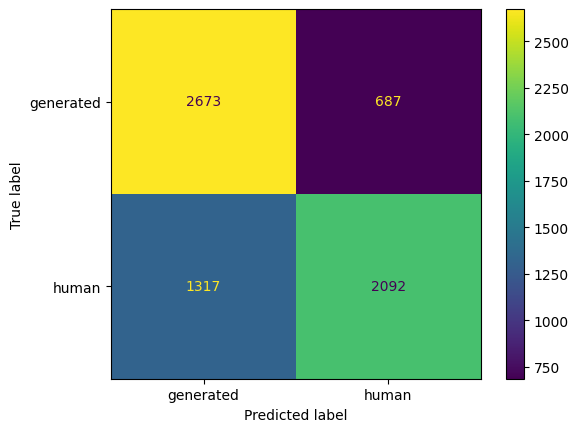

Linear Regression
Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}
Best CV score: 0.7613753169365146
              precision    recall  f1-score   support

   generated       0.77      0.77      0.77      3360
       human       0.77      0.78      0.78      3409

    accuracy                           0.77      6769
   macro avg       0.77      0.77      0.77      6769
weighted avg       0.77      0.77      0.77      6769



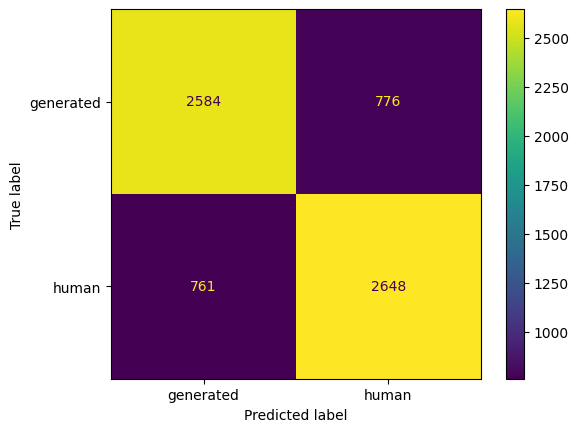

SVC
Best parameters: {'C': 1, 'kernel': 'rbf'}
Best CV score: 0.7623758241758243
              precision    recall  f1-score   support

   generated       0.79      0.78      0.79      3360
       human       0.79      0.80      0.79      3409

    accuracy                           0.79      6769
   macro avg       0.79      0.79      0.79      6769
weighted avg       0.79      0.79      0.79      6769



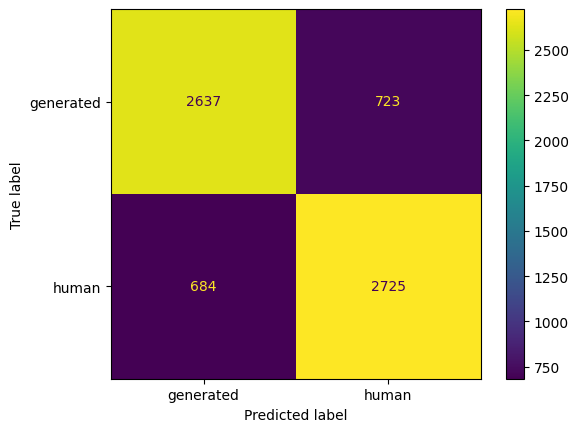

In [35]:
for model in models:
    print(f"{model['name']}")
    print(f"Best parameters: {model['model'].best_params_}")
    print(f"Best CV score: {model['model'].best_score_}")
    y_pred = model['best'].predict(x_test)
    evaluate(y_test, y_pred, labels=labels)

In [13]:
# Vectorize lemmas
vectorizer = CountVectorizer()
parsed_df["text_lem"] = parsed_df["features"].apply(lambda x: " ".join([t["lem"] for t in x]))
x_lem = vectorizer.fit_transform(parsed_df["text_lem"])

# Vectorize POS tags
vectorizer = CountVectorizer()
parsed_df["text_pos"] = parsed_df["features"].apply(lambda x: " ".join([t["pos"] for t in x]))
x_pos = vectorizer.fit_transform(parsed_df["text_pos"])

In [14]:
# Concatenate vectors
x = sps.hstack([x_lem, x_pos])
y = parsed_df["label"]

In [15]:
x_train, x_val, x_test, y_train, y_val, y_test = split(x, y, test_size=0.2, val_size=0.0)

In [18]:
models = []

# Naive Bayes
nb = MultinomialNB()
nb_param = {"alpha":[0.001, 0.01, 0.1, 1, 10, 100]}
nb_clf = GridSearchCV(nb, nb_param, cv=5, scoring="f1_micro", verbose=1)
models.append({"name": "Naive Bayes", "model": nb_clf})

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr_param = [{
    "solver": ["liblinear"], 
    "penalty": ["l1", "l2"],
    "C":[0.01, 0.1, 1, 10]
},{
    "solver": ("lbfgs", "sag", "saga"), 
    "penalty": ["l2"],
    "C":[0.01, 0.1, 1]
}]
lr_clf = GridSearchCV(lr, lr_param, cv=5, scoring="f1_micro", verbose=1)
models.append({"name": "Linear Regression", "model": lr_clf})

# SVC
svc = SVC()
svc_param = {"kernel": ["rbf"], "C": [0.1, 1, 10]}
svc_clf = GridSearchCV(svc, svc_param, cv=5, scoring="f1_micro", verbose=1)
models.append({"name": "SVC", "model": svc_clf, "subsample": 0.7})

# Decision Tree
dtree = DecisionTreeClassifier()
dtree_param = {
    "criterion": ["gini", "entropy"], 
    # "min_samples_split": [2, 4, 8],
    # "min_samples_leaf": [1, 2, 4],
    "max_features": [None, "sqrt", "log2"],
}
dtree_clf =  GridSearchCV(dtree, dtree_param, cv=5, scoring="f1_micro", verbose=1)
models.append({"name": "Decision Tree", "model": dtree_clf})

# Random Forest
rf = RandomForestClassifier()
rf_param = {
    # "n_estimators": [50, 100, 200, 400],
    # "max_depth": [None, 5, 10],
    "criterion": ["gini", "entropy"],
    # "min_samples_split": [2, 4, 8],
    # "min_samples_leaf": [1, 2, 4],
    # "max_features": [None, "sqrt", "log2"],
    # "oob_score": [True, False]
}
rf_clf =  GridSearchCV(rf, rf_param, cv=5, scoring="f1_micro", verbose=1)
models.append({"name": "Random Forest", "model": rf_clf})

# Extra Trees
et = ExtraTreesClassifier()
et_param = {
    # "n_estimators": [50, 100, 200, 400],
    # "max_depth": [None, 5, 10],
    "criterion": ["gini", "entropy"],
    # "min_samples_split": [2, 4, 8],
    # "min_samples_leaf": [1, 2, 4],
    # "max_features": [None, "sqrt", "log2"],
    # "oob_score": [True, False]
}
et_clf =  GridSearchCV(et, et_param, cv=5, scoring="f1_micro", verbose=1)
models.append({"name": "Extra Trees", "model": et_clf})

In [19]:
for model in models:
    print(f"Training {model['name']}")
    
    x_train_, y_train_ = x_train, y_train
    if "subsample" in model.keys():
        x_train_, _, y_train_, _ = train_test_split(
            x_train, 
            y_train, 
            test_size=model["subsample"], 
            stratify=y_train
        )
        
    model["model"].fit(x_train_, y_train_)
    
    print("Found best model")
    model["best"] = model["model"].best_estimator_
    model["best"].fit(x_train, y_train)
    print("Trained best model")

Training Naive Bayes
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Found best model
Trained best model
Training Linear Regression
Fitting 5 folds for each of 17 candidates, totalling 85 fits


/home/riga/.cache/pypoetry/virtualenvs/nlp-project-McHdYL_A-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/riga/.cache/pypoetry/virtualenvs/nlp-project-McHdYL_A-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative s

Found best model
Trained best model
Training SVC
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Found best model
Trained best model
Training Decision Tree
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Found best model
Trained best model
Training Random Forest
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Found best model
Trained best model
Training Extra Trees
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Found best model
Trained best model


Naive Bayes
Best parameters: {'alpha': 1}
Best CV score: 0.6861801222328151
              precision    recall  f1-score   support

   generated       0.64      0.81      0.71      3360
       human       0.74      0.54      0.63      3409

    accuracy                           0.68      6769
   macro avg       0.69      0.68      0.67      6769
weighted avg       0.69      0.68      0.67      6769



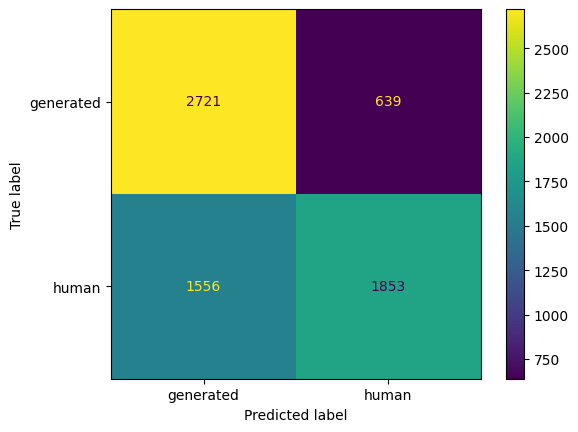

Linear Regression
Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'sag'}
Best CV score: 0.7782539883877461
              precision    recall  f1-score   support

   generated       0.78      0.77      0.78      3360
       human       0.78      0.79      0.78      3409

    accuracy                           0.78      6769
   macro avg       0.78      0.78      0.78      6769
weighted avg       0.78      0.78      0.78      6769



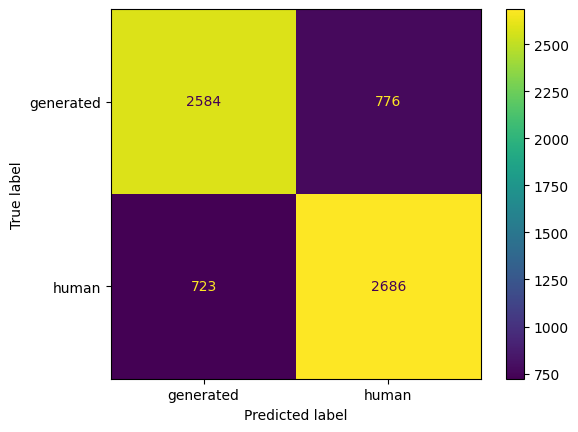

SVC
Best parameters: {'C': 10, 'kernel': 'rbf'}
Best CV score: 0.8016488821523303
              precision    recall  f1-score   support

   generated       0.82      0.82      0.82      3360
       human       0.82      0.82      0.82      3409

    accuracy                           0.82      6769
   macro avg       0.82      0.82      0.82      6769
weighted avg       0.82      0.82      0.82      6769



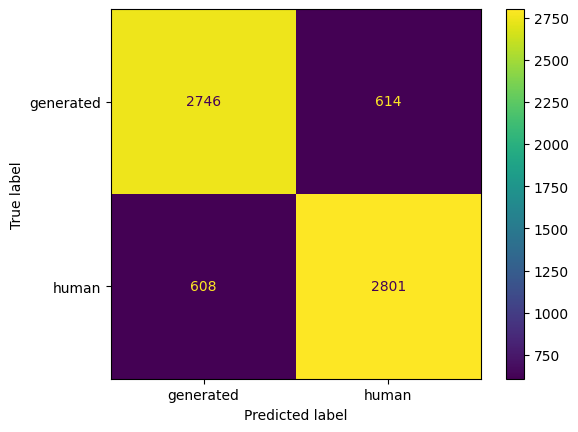

Decision Tree
Best parameters: {'criterion': 'gini', 'max_features': None}
Best CV score: 0.7217089066832518
              precision    recall  f1-score   support

   generated       0.71      0.72      0.72      3360
       human       0.72      0.71      0.72      3409

    accuracy                           0.72      6769
   macro avg       0.72      0.72      0.72      6769
weighted avg       0.72      0.72      0.72      6769



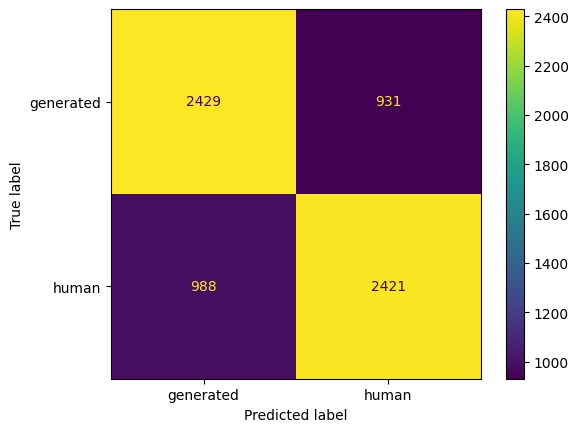

Random Forest
Best parameters: {'criterion': 'entropy'}
Best CV score: 0.7858621491534948
              precision    recall  f1-score   support

   generated       0.75      0.87      0.80      3360
       human       0.85      0.71      0.77      3409

    accuracy                           0.79      6769
   macro avg       0.80      0.79      0.79      6769
weighted avg       0.80      0.79      0.79      6769



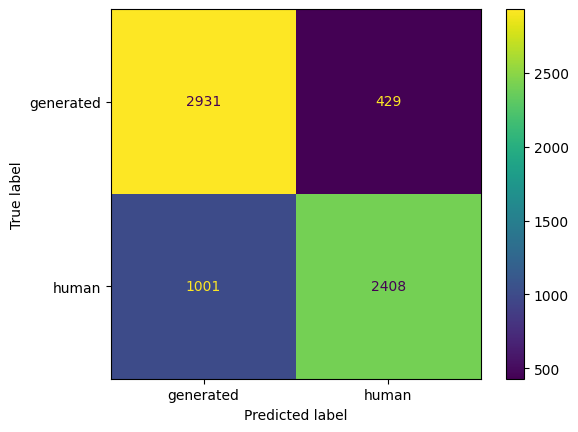

Extra Trees
Best parameters: {'criterion': 'entropy'}
Best CV score: 0.7797315092520231
              precision    recall  f1-score   support

   generated       0.73      0.88      0.79      3360
       human       0.85      0.67      0.75      3409

    accuracy                           0.77      6769
   macro avg       0.79      0.78      0.77      6769
weighted avg       0.79      0.77      0.77      6769



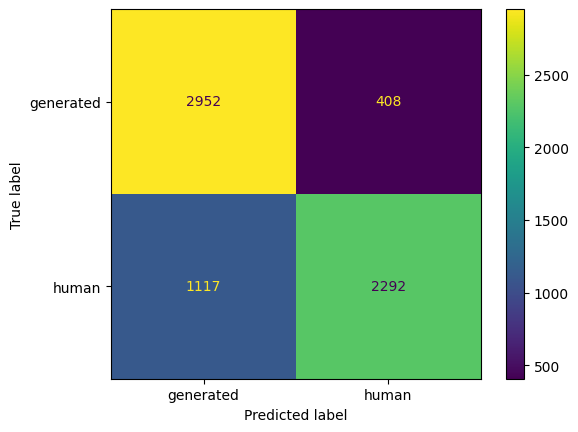

In [20]:
for model in models:
    print(f"{model['name']}")
    print(f"Best parameters: {model['model'].best_params_}")
    print(f"Best CV score: {model['model'].best_score_}")
    y_pred = model['best'].predict(x_test)
    evaluate(y_test, y_pred, labels=labels)

In [24]:
in_dim = x.shape[1]
out_dim = 1

epochs = 100
batch_size = 32

num_workers = 8 # Tune it based on your machine specs
device = init_gpu()

In [27]:
class Network(Classifier):
    def __init__(self, in_dim, out_dim, binary_classifier=False, device=torch.device("cpu"), verbose=True):
        super().__init__(binary_classifier, device, verbose)
        self.l1 = nn.Linear(in_dim, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, out_dim)
        self.dp = nn.Dropout(p=0.6)
        
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.l1(x))
        x = self.dp(x)
        x = self.sig(self.l3(x))
        return x

In [34]:
y_ = LabelBinarizer().fit_transform(y).astype(float)
x_train, x_val, x_test, y_train, y_val, y_test = split(x, y_, test_size=0.1, val_size=0.1)
ds_train = Data(x_train, y_train)
ds_val = Data(x_val, y_val)
ds_test = Data(x_test, y_test)

train_dl = dt.DataLoader(
    ds_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    # pin_memory_device=device.type, # Doesn't work on CPU
)
val_dl = dt.DataLoader(ds_val,     
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    # pin_memory_device=device.type, # Doesn't work on CPU
)
test_dl = dt.DataLoader(ds_test, batch_size=batch_size, shuffle=False)

In [43]:
nn_model = Network(in_dim, out_dim, binary_classifier=True, device=device)
loss = nn.BCELoss()
optimizer = opt.Adam(nn_model.parameters(), lr=0.01)
nn_model.compile(loss, optimizer)

In [44]:
earlystop = EarlyStopping(metric="val_acc", patience=10, baseline=0.7)
lradjust = AdaptLR(metric="val_acc", patience=5, factor=0.1)
callbacks = [earlystop, lradjust]
history = nn_model.train_loop(train_dl, epochs, data_val=val_dl, callbacks=callbacks)

Epoch 1 -- loss: 0.0170208 acc: 0.7087827 val_loss: 0.0166344 val_acc: 0.7163959
Epoch 2 -- loss: 0.0147975 acc: 0.7594548 val_loss: 0.0158334 val_acc: 0.7391433
Epoch 3 -- loss: 0.0133381 acc: 0.7890382 val_loss: 0.0161384 val_acc: 0.7400295
Epoch 4 -- loss: 0.0120679 acc: 0.8088344 val_loss: 0.0178643 val_acc: 0.7474151
Epoch 5 -- loss: 0.0111501 acc: 0.8212439 val_loss: 0.0167173 val_acc: 0.7506647
Epoch 6 -- loss: 0.0104888 acc: 0.8382331 val_loss: 0.0180227 val_acc: 0.7545052
Epoch 7 -- loss: 0.0099676 acc: 0.8434038 val_loss: 0.0207474 val_acc: 0.7415066
Epoch 8 -- loss: 0.0093322 acc: 0.8514183 val_loss: 0.0189439 val_acc: 0.7491876
Epoch 9 -- loss: 0.0087992 acc: 0.8589895 val_loss: 0.0210610 val_acc: 0.7539144
Epoch 10 -- loss: 0.0083691 acc: 0.8656744 val_loss: 0.0226612 val_acc: 0.7545052
Epoch 11 -- loss: 0.0081991 acc: 0.8700325 val_loss: 0.0248679 val_acc: 0.7465288
Epoch 12 -- loss: 0.0077172 acc: 0.8732826 val_loss: 0.0254158 val_acc: 0.7669129
Epoch 13 -- loss: 0.00769

{'acc': tensor(0.7775), 'loss': 0.024299896984904933}
              precision    recall  f1-score   support

         0.0       0.79      0.75      0.77      1680
         1.0       0.76      0.81      0.79      1704

    accuracy                           0.78      3384
   macro avg       0.78      0.78      0.78      3384
weighted avg       0.78      0.78      0.78      3384



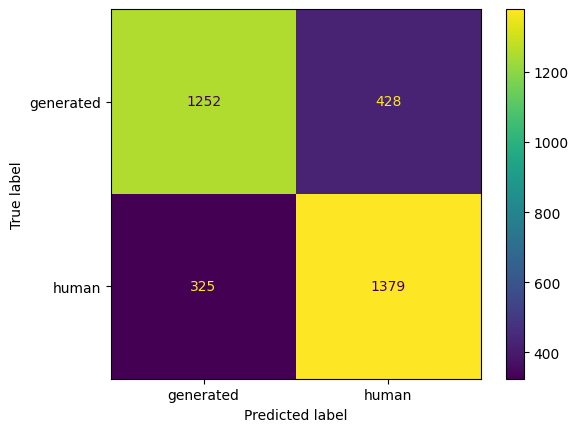

In [45]:
y_pred, metrics = nn_model.test_loop(test_dl)
print(metrics)
evaluate(y_test, y_pred, labels=labels)

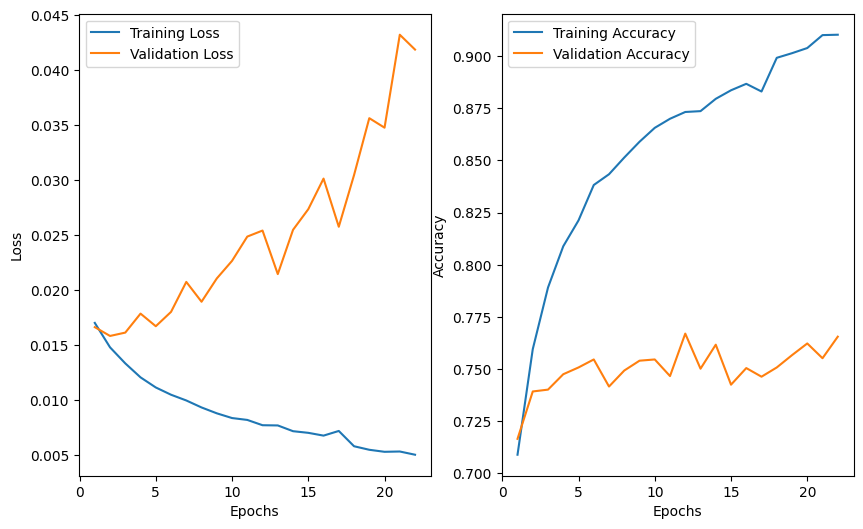

In [46]:
history = nn_model.history
plt_epochs = [h["epoch"] for h in history]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

tl = ax1.plot(plt_epochs, [h["loss"] for h in history], label="Training Loss")
vl = ax1.plot(plt_epochs, [h["val_loss"] for h in history], label="Validation Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

ta = ax2.plot(plt_epochs, [h["acc"] for h in history], label="Training Accuracy")
va = ax2.plot(plt_epochs, [h["val_acc"] for h in history], label="Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()

plt.show()